<a href="https://colab.research.google.com/github/Amirbn73/Air-Pollution-Prediction-PM2.5/blob/main/PM2_5_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from time import time

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
file = files.upload()

Saving trainData.csv to trainData.csv
Saving testData.csv to testData.csv


In [ ]:
import pandas as pd
dfTest = pd.read_csv('testData.csv')
dfTest.head()

,Daily_Maximum_Air_Temperature,Daily_Minimum_Air_Temperature,Daily_Rainfall_Total,Daily_Maximum_Gust_Speed,Daily_Mean_Wind_Speed,PM25,Year,Month,Dis2MR,Dis2MJR
0,9.472744,3.654333,1.539482,20.932165,7.633981,11.32258,2019.0,Jan,360.0,2552.3372
1,9.479849,3.660998,1.541262,20.942200,7.638065,11.32258,2019.0,Jan,315.0,2545.5845
2,9.486860,3.667572,1.543019,20.952087,7.642077,11.32258,2019.0,Jan,270.0,2539.6110
3,9.493773,3.674051,1.544751,20.961819,7.646015,11.32258,2019.0,Jan,225.0,2534.4230
4,9.500581,3.680429,1.546458,20.971386,7.649872,11.32258,2019.0,Jan,180.0,2530.0247


In [ ]:
dfTrain = pd.read_csv('trainData.csv')
dfTrain.head()

,Daily_Maximum_Air_Temperature,Daily_Minimum_Air_Temperature,Daily_Rainfall_Total,Daily_Maximum_Gust_Speed,Daily_Mean_Wind_Speed,PM25,Year,Month,Dis2MR,Dis2MJR
0,7.647924,1.998089,1.075357,18.647802,6.922074,11.329196,2019.0,Jan,315.0,315.00000
1,7.649388,1.999116,1.075767,18.648050,6.920820,11.329291,2019.0,Jan,315.0,315.00000
2,7.650972,2.000228,1.076210,18.648317,6.919464,11.329486,2019.0,Jan,315.0,315.00000
3,7.652679,2.001425,1.076689,18.648605,6.918003,11.329781,2019.0,Jan,315.0,318.19806
4,7.654510,2.002711,1.077202,18.648912,6.916435,11.330178,2019.0,Jan,315.0,327.60495


In [ ]:
!git clone https://github.com/PetraVidnerova/rbf_keras.git

Cloning into 'rbf_keras'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 124 (delta 2), reused 3 (delta 0), pack-reused 116
Receiving objects: 100% (124/124), 25.19 KiB | 12.59 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
from sklearn.model_selection import KFold
import keras
from keras import layers
import tensorflow
from rbf_keras import kmeans_initializer
from keras.optimizers import RMSprop

In [ ]:
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np


class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
      assert shape[1] == self.X.shape[1]
      idx = np.random.randint(self.X.shape[0], size=shape[0])

	# type checking to access elements of data correctly
      if type(self.X) == np.ndarray:
          return self.X[idx, :]
      elif type(self.X) == pd.core.frame.DataFrame:
          return self.X.iloc[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```


    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dfTrain.head()

,Daily_Maximum_Air_Temperature,Daily_Minimum_Air_Temperature,Daily_Rainfall_Total,Daily_Maximum_Gust_Speed,Daily_Mean_Wind_Speed,PM25,Year,Month,Dis2MR,Dis2MJR
0,7.647924,1.998089,1.075357,18.647802,6.922074,11.329196,2019.0,Jan,315.0,315.00000
1,7.649388,1.999116,1.075767,18.648050,6.920820,11.329291,2019.0,Jan,315.0,315.00000
2,7.650972,2.000228,1.076210,18.648317,6.919464,11.329486,2019.0,Jan,315.0,315.00000
3,7.652679,2.001425,1.076689,18.648605,6.918003,11.329781,2019.0,Jan,315.0,318.19806
4,7.654510,2.002711,1.077202,18.648912,6.916435,11.330178,2019.0,Jan,315.0,327.60495


In [ ]:
dfTest.head()

,Daily_Maximum_Air_Temperature,Daily_Minimum_Air_Temperature,Daily_Rainfall_Total,Daily_Maximum_Gust_Speed,Daily_Mean_Wind_Speed,PM25,Year,Month,Dis2MR,Dis2MJR
0,9.472744,3.654333,1.539482,20.932165,7.633981,11.32258,2019.0,Jan,360.0,2552.3372
1,9.479849,3.660998,1.541262,20.942200,7.638065,11.32258,2019.0,Jan,315.0,2545.5845
2,9.486860,3.667572,1.543019,20.952087,7.642077,11.32258,2019.0,Jan,270.0,2539.6110
3,9.493773,3.674051,1.544751,20.961819,7.646015,11.32258,2019.0,Jan,225.0,2534.4230
4,9.500581,3.680429,1.546458,20.971386,7.649872,11.32258,2019.0,Jan,180.0,2530.0247


In [ ]:
dfTrain.columns = dfTrain.columns.to_series().apply(lambda x: x.replace('Daily_', ''))

In [ ]:
dfTest.columns = dfTest.columns.to_series().apply(lambda x: x.replace('Daily_', ''))

In [ ]:
# Create dummy variables for the 'Month' column with drop_first=True
df_dummies = pd.get_dummies(dfTrain['Month'], prefix='Month', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
dfTrain = pd.concat([dfTrain, df_dummies], axis=1)

# Drop the original 'Month' column since we now have dummy variables
dfTrain.drop('Month', axis=1, inplace = True)

dfTrain.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM25,Year,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,7.647924,1.998089,1.075357,18.647802,6.922074,11.329196,2019.0,315.0,315.00000,0,0,0,1,0,0,0,0,0,0,0
1,7.649388,1.999116,1.075767,18.648050,6.920820,11.329291,2019.0,315.0,315.00000,0,0,0,1,0,0,0,0,0,0,0
2,7.650972,2.000228,1.076210,18.648317,6.919464,11.329486,2019.0,315.0,315.00000,0,0,0,1,0,0,0,0,0,0,0
3,7.652679,2.001425,1.076689,18.648605,6.918003,11.329781,2019.0,315.0,318.19806,0,0,0,1,0,0,0,0,0,0,0
4,7.654510,2.002711,1.077202,18.648912,6.916435,11.330178,2019.0,315.0,327.60495,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Create dummy variables for the 'Month' column with drop_first=True
df_dummies = pd.get_dummies(dfTrain['Year'], prefix='Year', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
dfTrain = pd.concat([dfTrain, df_dummies], axis=1)

# Drop the original 'Month' column since we now have dummy variables
dfTrain.drop('Year', axis=1, inplace = True)

dfTrain.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM25,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2020.0,Year_2021.0
0,7.647924,1.998089,1.075357,18.647802,6.922074,11.329196,315.0,315.00000,0,0,...,1,0,0,0,0,0,0,0,0,0
1,7.649388,1.999116,1.075767,18.648050,6.920820,11.329291,315.0,315.00000,0,0,...,1,0,0,0,0,0,0,0,0,0
2,7.650972,2.000228,1.076210,18.648317,6.919464,11.329486,315.0,315.00000,0,0,...,1,0,0,0,0,0,0,0,0,0
3,7.652679,2.001425,1.076689,18.648605,6.918003,11.329781,315.0,318.19806,0,0,...,1,0,0,0,0,0,0,0,0,0
4,7.654510,2.002711,1.077202,18.648912,6.916435,11.330178,315.0,327.60495,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Create dummy variables for the 'Month' column with drop_first=True
ds_dummies = pd.get_dummies(dfTest['Month'], prefix='Month', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
dfTest = pd.concat([dfTest, ds_dummies], axis=1)

# Drop the original 'Month' column since we now have dummy variables
dfTest.drop('Month', axis=1, inplace = True)

dfTest.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM25,Year,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,9.472744,3.654333,1.539482,20.932165,7.633981,11.32258,2019.0,360.0,2552.3372,0,0,0,1,0,0,0,0,0,0,0
1,9.479849,3.660998,1.541262,20.942200,7.638065,11.32258,2019.0,315.0,2545.5845,0,0,0,1,0,0,0,0,0,0,0
2,9.486860,3.667572,1.543019,20.952087,7.642077,11.32258,2019.0,270.0,2539.6110,0,0,0,1,0,0,0,0,0,0,0
3,9.493773,3.674051,1.544751,20.961819,7.646015,11.32258,2019.0,225.0,2534.4230,0,0,0,1,0,0,0,0,0,0,0
4,9.500581,3.680429,1.546458,20.971386,7.649872,11.32258,2019.0,180.0,2530.0247,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Create dummy variables for the 'Month' column with drop_first=True
ds_dummies = pd.get_dummies(dfTest['Year'], prefix='Year', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
dfTest = pd.concat([dfTest, ds_dummies], axis=1)

# Drop the original 'Month' column since we now have dummy variables
dfTest.drop('Year', axis=1, inplace = True)

dfTest.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM25,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2020.0,Year_2021.0
0,9.472744,3.654333,1.539482,20.932165,7.633981,11.32258,360.0,2552.3372,0,0,...,1,0,0,0,0,0,0,0,0,0
1,9.479849,3.660998,1.541262,20.942200,7.638065,11.32258,315.0,2545.5845,0,0,...,1,0,0,0,0,0,0,0,0,0
2,9.486860,3.667572,1.543019,20.952087,7.642077,11.32258,270.0,2539.6110,0,0,...,1,0,0,0,0,0,0,0,0,0
3,9.493773,3.674051,1.544751,20.961819,7.646015,11.32258,225.0,2534.4230,0,0,...,1,0,0,0,0,0,0,0,0,0
4,9.500581,3.680429,1.546458,20.971386,7.649872,11.32258,180.0,2530.0247,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
correlation_matrix = dfTrain.corr()

# Display the correlation matrix
correlation_matrix

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM25,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2020.0,Year_2021.0
Maximum_Air_Temperature,1.000000,0.954846,-0.009116,-0.302288,-0.203654,-0.321571,1.706006e-03,-5.967480e-03,3.993975e-01,-3.475436e-01,...,-4.253845e-01,4.239978e-01,3.393100e-01,-2.069657e-01,1.036935e-01,-2.325993e-01,-7.328358e-05,3.058836e-01,7.442799e-03,-6.474891e-02
Minimum_Air_Temperature,0.954846,1.000000,0.175872,-0.303099,-0.171294,-0.467639,4.486821e-03,-1.569995e-02,4.479925e-01,-2.402237e-01,...,-3.573674e-01,4.455201e-01,3.437879e-01,-2.479610e-01,-2.096867e-02,-2.087787e-01,8.258255e-02,3.022603e-01,2.125944e-02,-3.070237e-02
Rainfall_Total,-0.009116,0.175872,1.000000,0.196177,0.079259,-0.378724,-4.202224e-03,1.305064e-02,-8.532286e-02,1.410408e-01,...,1.543511e-01,8.961622e-02,1.401224e-01,-2.101328e-01,-8.708830e-02,-2.404088e-01,5.786315e-01,-1.081227e-01,3.841925e-02,6.680931e-03
Maximum_Gust_Speed,-0.302288,-0.303099,0.196177,1.000000,0.859081,0.002227,3.651118e-02,-1.163287e-01,-6.519979e-02,3.127081e-02,...,-6.130035e-02,-1.687872e-01,-1.843153e-01,3.110566e-01,1.507748e-01,-2.584669e-01,1.337823e-01,-2.541108e-01,1.027369e-01,-2.698621e-01
Mean_Wind_Speed,-0.203654,-0.171294,0.079259,0.859081,1.000000,-0.059729,7.481475e-02,-2.351043e-01,-2.977558e-02,2.545075e-02,...,-3.524418e-02,-1.074245e-01,-8.655531e-02,2.364657e-01,-5.552643e-03,-1.646465e-01,2.413552e-02,-1.365743e-01,1.134179e-01,-1.966445e-01
PM25,-0.321571,-0.467639,-0.378724,0.002227,-0.059729,1.000000,-5.346723e-03,3.062194e-02,-2.241128e-01,-8.162542e-02,...,1.134177e-01,-1.996924e-01,-1.407812e-01,1.146554e-01,-1.068929e-01,1.577393e-01,-2.274197e-01,-1.200564e-01,-2.235222e-01,-1.744532e-01
Dis2MR,0.001706,0.004487,-0.004202,0.036511,0.074815,-0.005347,1.000000e+00,1.512071e-01,-1.793648e-16,3.847251e-15,...,-2.202990e-16,-1.138148e-15,1.925179e-16,-1.013212e-15,-9.701338e-16,3.117238e-16,-9.894884e-16,1.008704e-16,7.318995e-15,8.322003e-16
Dis2MJR,-0.005967,-0.015700,0.013051,-0.116329,-0.235104,0.030622,1.512071e-01,1.000000e+00,2.457183e-15,-3.781511e-15,...,-1.246114e-15,1.904651e-15,1.076148e-15,6.801005e-16,-4.070745e-16,-1.502677e-15,3.921297e-16,1.400331e-15,-2.736441e-15,-8.318096e-16
Month_Aug,0.399397,0.447993,-0.085323,-0.065200,-0.029776,-0.224113,-1.793648e-16,2.457183e-15,1.000000e+00,-9.090909e-02,...,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,5.020043e-15,-4.679634e-15
Month_Dec,-0.347544,-0.240224,0.141041,0.031271,0.025451,-0.081625,3.847251e-15,-3.781511e-15,-9.090909e-02,1.000000e+00,...,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,4.348450e-15,-3.685184e-15


In [ ]:
correlation_matrix[correlation_matrix > 0.8]

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM25,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2020.0,Year_2021.0
Maximum_Air_Temperature,1.000000,0.954846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minimum_Air_Temperature,0.954846,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfall_Total,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum_Gust_Speed,NaN,NaN,NaN,1.000000,0.859081,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mean_Wind_Speed,NaN,NaN,NaN,0.859081,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PM25,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dis2MR,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dis2MJR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Aug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Dec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
correlation_matrix['PM25']

Maximum_Air_Temperature   -0.321571
Minimum_Air_Temperature   -0.467639
Rainfall_Total            -0.378724
Maximum_Gust_Speed         0.002227
Mean_Wind_Speed           -0.059729
PM25                       1.000000
Dis2MR                    -0.005347
Dis2MJR                    0.030622
Month_Aug                 -0.224113
Month_Dec                 -0.081625
Month_Feb                  0.147528
Month_Jan                  0.113418
Month_Jul                 -0.199692
Month_Jun                 -0.140781
Month_Mar                  0.114655
Month_May                 -0.106893
Month_Nov                  0.157739
Month_Oct                 -0.227420
Month_Sep                 -0.120056
Year_2020.0               -0.223522
Year_2021.0               -0.174453
Name: PM25, dtype: float64

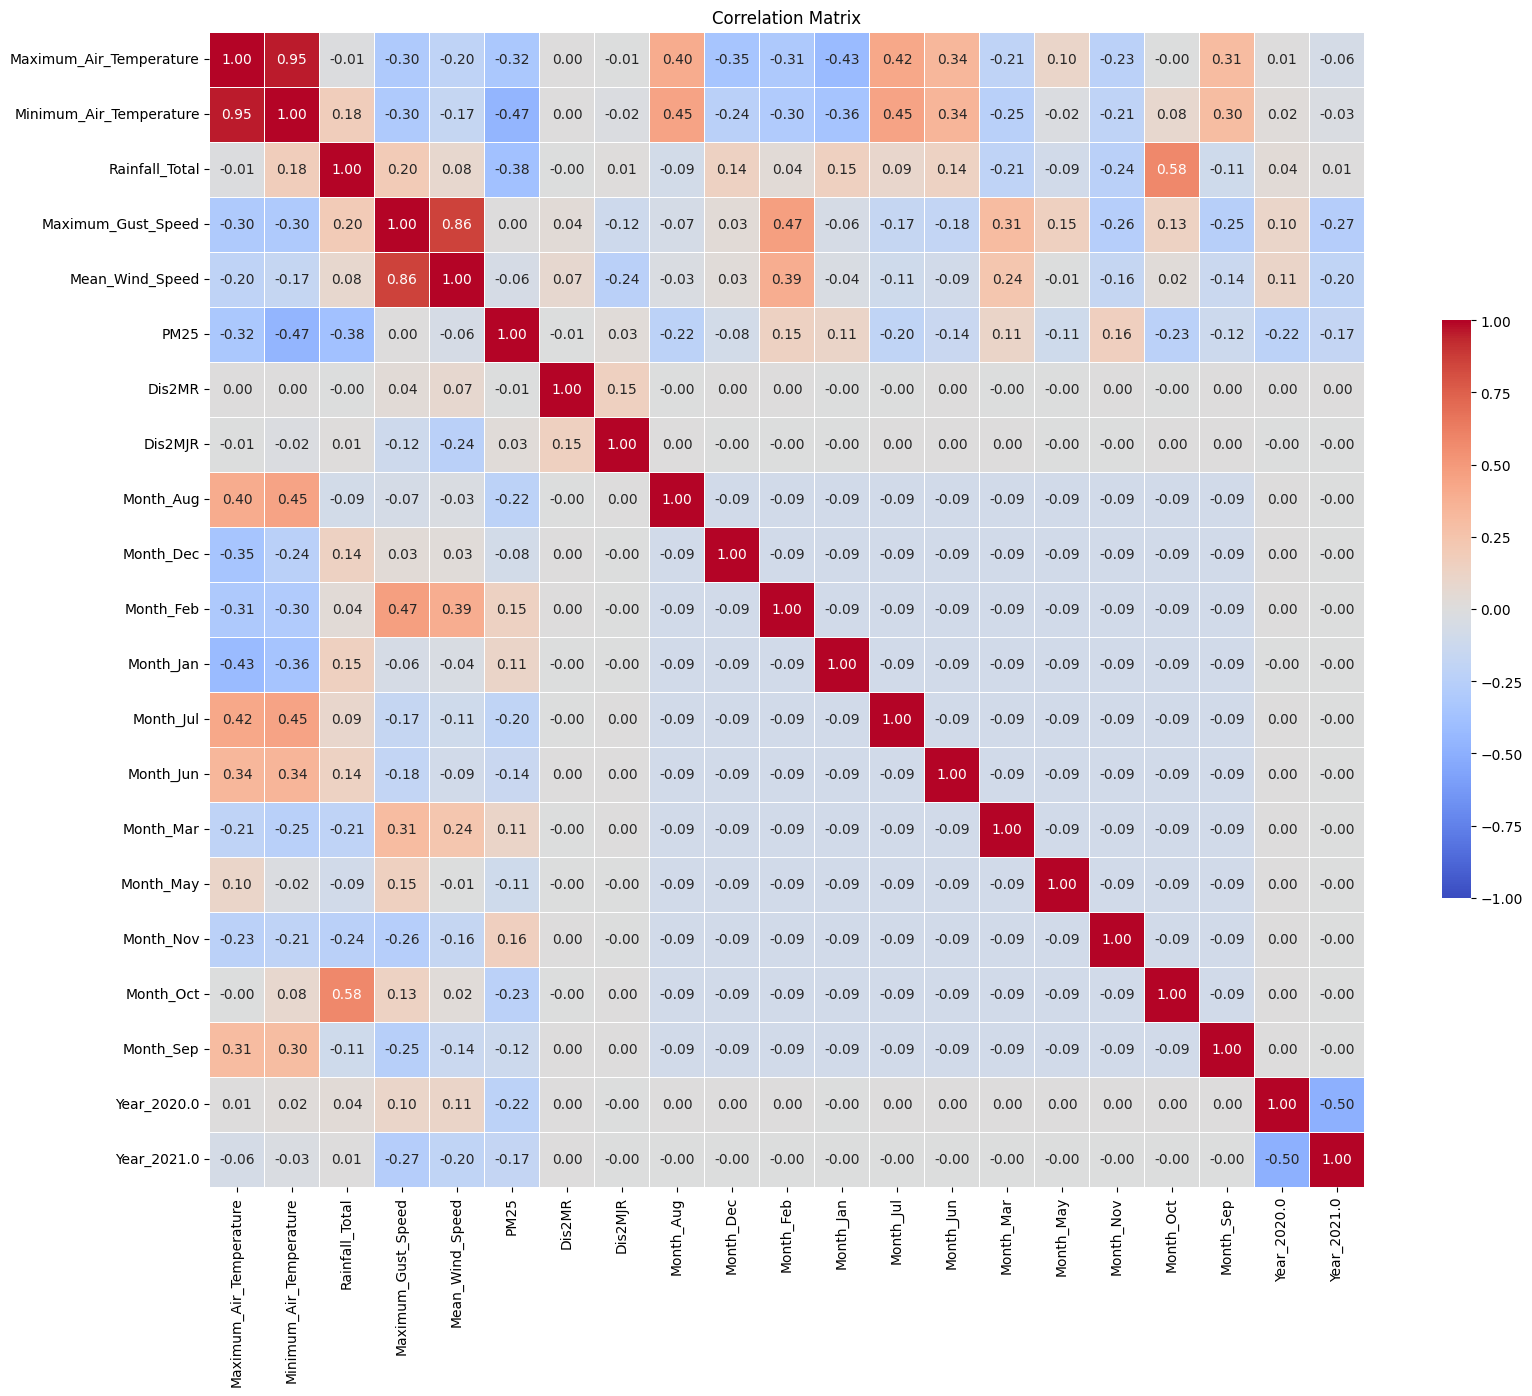

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your DataFrame named df
correlation_matrix = dfTrain.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('Correlation Matrix')

# Rotate the y-axis labels for better visibility
plt.yticks(rotation=0)

# Show the plot
plt.show()


In [ ]:
filtered_df = correlation_matrix[correlation_matrix > 0.5]

# Display the filtered DataFrame
filtered_df

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM25,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2020.0,Year_2021.0
Maximum_Air_Temperature,1.000000,0.954846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minimum_Air_Temperature,0.954846,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfall_Total,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.578632,NaN,NaN,NaN
Maximum_Gust_Speed,NaN,NaN,NaN,1.000000,0.859081,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mean_Wind_Speed,NaN,NaN,NaN,0.859081,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PM25,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dis2MR,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dis2MJR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Aug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Dec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dfTrain.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM25,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2020.0,Year_2021.0
0,7.647924,1.998089,1.075357,18.647802,6.922074,11.329196,315.0,315.00000,0,0,...,1,0,0,0,0,0,0,0,0,0
1,7.649388,1.999116,1.075767,18.648050,6.920820,11.329291,315.0,315.00000,0,0,...,1,0,0,0,0,0,0,0,0,0
2,7.650972,2.000228,1.076210,18.648317,6.919464,11.329486,315.0,315.00000,0,0,...,1,0,0,0,0,0,0,0,0,0
3,7.652679,2.001425,1.076689,18.648605,6.918003,11.329781,315.0,318.19806,0,0,...,1,0,0,0,0,0,0,0,0,0
4,7.654510,2.002711,1.077202,18.648912,6.916435,11.330178,315.0,327.60495,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_vif = dfTrain[['Rainfall_Total', 'Dis2MR', 'Mean_Wind_Speed', 'Maximum_Gust_Speed', 'Minimum_Air_Temperature', 'Maximum_Air_Temperature', 'Dis2MJR']]
vif = pd.DataFrame()
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif

,features,vif_Factor
0,Rainfall_Total,10.068778
1,Dis2MR,2.590342
2,Mean_Wind_Speed,98.974885
3,Maximum_Gust_Speed,229.694140
4,Minimum_Air_Temperature,100.614972
5,Maximum_Air_Temperature,191.303061
6,Dis2MJR,2.851614


In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame and 'column1', 'column2', ... are the columns to be normalized
columns_to_normalize = ['Maximum_Air_Temperature', 'Minimum_Air_Temperature', 'Rainfall_Total', 'Maximum_Gust_Speed', 'Mean_Wind_Speed', 'Dis2MR', 'Dis2MJR']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
dfTrain[columns_to_normalize] = scaler.fit_transform(dfTrain[columns_to_normalize])

# Print the normalized DataFrame
dfTrain.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM25,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2020.0,Year_2021.0
0,-1.514339,-1.306135,-0.813285,-0.319723,0.589136,11.329196,-0.002723,-0.793045,0,0,...,1,0,0,0,0,0,0,0,0,0
1,-1.514076,-1.305896,-0.812883,-0.319632,0.588262,11.329291,-0.002723,-0.793045,0,0,...,1,0,0,0,0,0,0,0,0,0
2,-1.513792,-1.305637,-0.812449,-0.319533,0.587318,11.329486,-0.002723,-0.793045,0,0,...,1,0,0,0,0,0,0,0,0,0
3,-1.513485,-1.305358,-0.811980,-0.319426,0.586301,11.329781,-0.002723,-0.788486,0,0,...,1,0,0,0,0,0,0,0,0,0
4,-1.513156,-1.305059,-0.811478,-0.319313,0.585209,11.330178,-0.002723,-0.775076,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame and 'column1', 'column2', ... are the columns to be normalized
columns_to_normalize = ['Maximum_Air_Temperature', 'Minimum_Air_Temperature', 'Rainfall_Total', 'Maximum_Gust_Speed', 'Mean_Wind_Speed', 'Dis2MJR', 'Dis2MR']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
dfTest[columns_to_normalize] = scaler.fit_transform(dfTest[columns_to_normalize])

# Print the normalized DataFrame
dfTest.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM25,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2020.0,Year_2021.0
0,-1.169541,-0.885451,-0.375571,0.424728,0.895710,11.32258,-0.101530,1.709568,0,0,...,1,0,0,0,0,0,0,0,0,0
1,-1.168259,-0.883916,-0.373832,0.428466,0.898652,11.32258,-0.243117,1.700400,0,0,...,1,0,0,0,0,0,0,0,0,0
2,-1.166995,-0.882402,-0.372117,0.432148,0.901543,11.32258,-0.384704,1.692290,0,0,...,1,0,0,0,0,0,0,0,0,0
3,-1.165747,-0.880911,-0.370424,0.435774,0.904380,11.32258,-0.526291,1.685246,0,0,...,1,0,0,0,0,0,0,0,0,0
4,-1.164519,-0.879442,-0.368757,0.439337,0.907159,11.32258,-0.667878,1.679275,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_vif = dfTrain[['Rainfall_Total', 'Dis2MR', 'Mean_Wind_Speed', 'Maximum_Gust_Speed', 'Minimum_Air_Temperature', 'Maximum_Air_Temperature', 'Dis2MJR']]
vif = pd.DataFrame()
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif

,features,vif_Factor
0,Rainfall_Total,2.267260
1,Dis2MR,1.045697
2,Mean_Wind_Speed,5.619857
3,Maximum_Gust_Speed,6.176436
4,Minimum_Air_Temperature,25.283291
5,Maximum_Air_Temperature,22.750265
6,Dis2MJR,1.133211


In [ ]:
import pandas as pd
dfTrain['Temp_Range'] = dfTrain['Maximum_Air_Temperature'] - dfTrain['Minimum_Air_Temperature']
dfTrain['Gust_Wind'] = dfTrain['Maximum_Gust_Speed'] - dfTrain['Mean_Wind_Speed']
# dfTrain['Gust_Wind'] = dfTrain[['Maximum_Gust_Speed', 'Mean_Wind_Speed']].mean(axis=1)

In [ ]:
import pandas as pd
dfTest['Temp_Range'] = dfTest['Maximum_Air_Temperature'] - dfTest['Minimum_Air_Temperature']
dfTest['Gust_Wind'] = dfTest['Maximum_Gust_Speed'] - dfTest['Mean_Wind_Speed']

In [ ]:
dfTrain.drop(['Minimum_Air_Temperature', 'Maximum_Air_Temperature', 'Maximum_Gust_Speed', 'Mean_Wind_Speed'], axis = 1, inplace = True)

In [ ]:
dfTest.drop(['Minimum_Air_Temperature', 'Maximum_Air_Temperature', 'Maximum_Gust_Speed', 'Mean_Wind_Speed'], axis = 1, inplace = True)

In [ ]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_vif = dfTrain[['Rainfall_Total', 'Dis2MR', 'Temp_Range', 'Gust_Wind', 'Dis2MJR']]
vif = pd.DataFrame()
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif

,features,vif_Factor
0,Rainfall_Total,2.034525
1,Dis2MR,1.037244
2,Temp_Range,2.020254
3,Gust_Wind,1.402960
4,Dis2MJR,1.090789


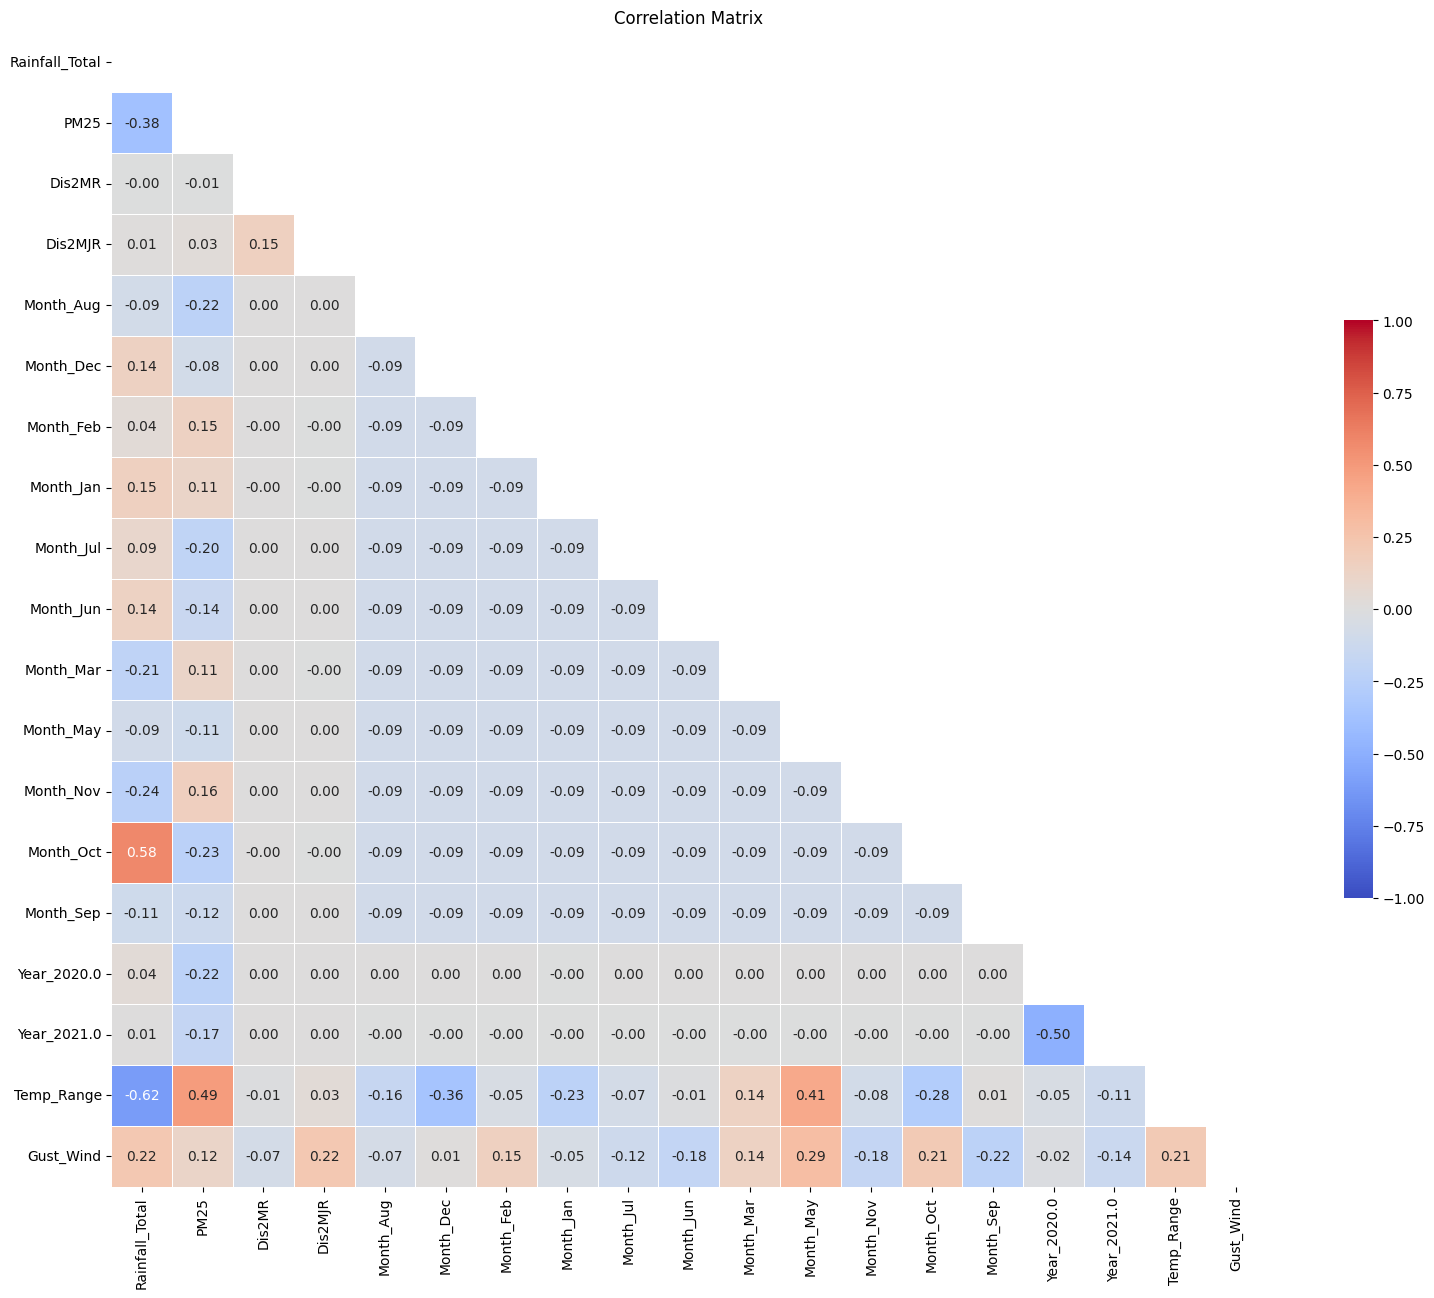

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your DataFrame named df
correlation_matrix = dfTrain.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Create the heatmap with the mask applied
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, mask=mask)

# Add title
plt.title('Correlation Matrix')

# Rotate the y-axis labels for better visibility
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [ ]:
import keras

In [ ]:
pm_variance = dfTrain['PM25'].var()

print("Variance of the column:",pm_variance )

Variance of the column: 11.573499257107898


In [ ]:
dfTrain.rename(columns={'PM25': 'PM2_5'}, inplace=True)
dfTest.rename(columns={'PM25': 'PM2_5'}, inplace=True)

In [ ]:
X = dfTrain.drop(['PM2_5'],axis = 1)
y = dfTrain[['PM2_5']]

In [ ]:
from sklearn.utils import shuffle

In [ ]:
XTrain_shuffled, yTrain_shuffled = shuffle(X, y, random_state=42)

In [ ]:
print(XTrain_shuffled.shape,yTrain_shuffled.shape)
XTrain_shuffled.head()

(1178892, 18) (1178892, 1)


,Rainfall_Total,Dis2MR,Dis2MJR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2020.0,Year_2021.0,Temp_Range,Gust_Wind
87049,-0.319640,1.502785,0.826649,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.054078,0.014627
399475,0.438207,-1.050580,-0.408153,0,0,0,1,0,0,0,0,0,0,0,1,0,-0.312985,-0.269881
312947,2.335654,0.663828,-0.788486,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.286488,0.573735
290553,-0.900271,-1.050580,2.328412,0,0,0,0,0,0,0,0,0,0,1,0,0,0.212591,0.236994
565499,0.294759,-1.050580,0.192323,0,0,0,0,0,1,0,0,0,0,0,1,0,-0.044982,-0.450762


In [ ]:
yTrain_shuffled.head()

,PM2_5
87049,9.458909
399475,9.396327
312947,8.955036
290553,7.703414
565499,6.381364


In [ ]:
X_tr, y_tr= XTrain_shuffled, yTrain_shuffled

In [ ]:
X_test = dfTest.drop(['PM2_5'],axis = 1)
y_test = dfTest[['PM2_5']]

In [ ]:
XTest_shuffled, yTest_shuffled = shuffle(X_test, y_test, random_state=42)

In [ ]:
XTest_shuffled.shape

(783180, 18)

In [ ]:
X_tst = XTest_shuffled[600000:]
y_tst = yTest_shuffled[600000:]

In [ ]:
X_Val = XTest_shuffled[:180000]
y_Val = yTest_shuffled[:180000]

In [ ]:
# X_Test, _, y_Test, _ = train_test_split(X_tst, y_tst, test_size=0.5, random_state=42)
X_Test, y_Test = X_tst, y_tst

In [ ]:
X_Test.shape, X_Val.shape, X_tr.shape

((183180, 18), (180000, 18), (1178892, 18))

In [ ]:
memory_X_tr, memory_X_tst, memory_X_val = X_tr, X_Test, X_Val

In [ ]:
X_tr, X_Test, X_Val = memory_X_tr, memory_X_tst, memory_X_val

In [ ]:
import time

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression
# Assuming X_tr and y_tr are your training data and labels
# Assuming X_Val and y_Val are your validation data and labels

# Step 2: Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42)

# Step 3: Create and train the linear regression model
linear_model = LinearRegression()
time1 = time.time()
linear_model.fit(X_tr, y_tr)
time2 = time.time()
span_multi_linear = time2 - time1
f_statistic, p_values = f_regression(X_tr, y_tr)
# Step 4: Evaluate the model on the validation set
predictions_linear = linear_model.predict(X_Test)
mae_linear = mean_absolute_error(y_Test, predictions_linear)
r_squared_linear = r2_score(y_Test, predictions_linear)

print("R-squared Score on Validation Set:", r_squared_linear)
print("Mean Absolute Error on Validation Set:", mae_linear)
# print("Number of iterations:", linear_model.n_iter_)
print(f'{span_multi_linear} second')

R-squared Score on Validation Set: 0.575909403171802
Mean Absolute Error on Validation Set: 1.6718369423675634
1.1399905681610107 second


In [ ]:
mean_squared_error(y_Test, predictions_linear)

4.457241824191426

In [ ]:
import time

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming X_tr, y_tr, X_Val, and y_Val are already defined

# Create and train the RandomForestRegressor
random_forest_model = RandomForestRegressor(n_estimators=30, random_state=42, verbose=2, n_jobs=-1)
time1 = time.time()
random_forest_model.fit(X_tr, y_tr)
time2 = time.time()
span_RFR = time2 - time1
# Make predictions on the validation set
y_tst_RFR_pred = random_forest_model.predict(X_Test)

# Calculate Mean Absolute Error (MAE)
RFR_mae = mean_absolute_error(y_Test, y_tst_RFR_pred)
print(f"Mean Absolute Error on Test Set: {RFR_mae}")
RFR_mse = mean_squared_error(y_Test, y_tst_RFR_pred)
print(f"Mean Squared Error on Test Set: {RFR_mse}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30


KeyboardInterrupt: 

In [ ]:
RFR_mse

1.292790623913255

In [ ]:
# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame to display/ feature importances
importance_df = pd.DataFrame({'Feature': X_tr.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(importance_df)

           Feature  Importance
16      Temp_Range    0.273914
0   Rainfall_Total    0.137658
14     Year_2020.0    0.119134
10       Month_May    0.093410
15     Year_2021.0    0.066862
17       Gust_Wind    0.061622
6        Month_Jan    0.059297
11       Month_Nov    0.048710
5        Month_Feb    0.047728
9        Month_Mar    0.041403
7        Month_Jul    0.016006
13       Month_Sep    0.015714
8        Month_Jun    0.004829
4        Month_Dec    0.004607
12       Month_Oct    0.004419
3        Month_Aug    0.002818
2          Dis2MJR    0.001343
1           Dis2MR    0.000526


In [ ]:
# Calculate R-squared
print(f'Time: {span_RFR} sec')
r_squared_RFR = r2_score(y_Test, y_tst_RFR_pred)
print(f"R-squared on Validation Set: {r_squared_RFR}")

Time: 71.94481563568115 sec
R-squared on Validation Set: 0.8769956020125228


In [ ]:
import time

In [ ]:
# if model:
#   del model
from tensorflow.keras import models

# Defining the first RBF layer
rbfLayer1 = RBFLayer(40,
                    initializer=kmeans_initializer.InitCentersKMeans(X_tr),
                    betas=0.25,
                    input_shape=([18]))

# Creating a Keras functional model with the first RBF layer as input
model_input = layers.Input(shape=(18,))
x1 = rbfLayer1(model_input)
model1 = models.Model(inputs=model_input, outputs=x1)

# Extracting the output of the first RBF layer as the new dataset for the second layer
X_rbfLayer1_output = model1.predict(X_tr)

# Defining the second RBF layer with the new dataset
rbfLayer2 = RBFLayer(40,
                    initializer=kmeans_initializer.InitCentersKMeans(X_rbfLayer1_output),
                    betas=0.25)

# Creating a Keras functional model with the first two RBF layers as input
model2_input = layers.Input(shape=(40,))
x2 = rbfLayer2(model2_input)
model2 = models.Model(inputs=model2_input, outputs=x2)

# Extracting the output of the second RBF layer as the new dataset for the third layer
X_rbfLayer2_output = model2.predict(X_rbfLayer1_output)

# Defining the third RBF layer with the new dataset
rbfLayer3 = RBFLayer(40,
                    initializer=kmeans_initializer.InitCentersKMeans(X_rbfLayer2_output),
                    betas=0.25)

# Building the model with three RBF layers
model = keras.models.Sequential()
model.add(rbfLayer1)
model.add(rbfLayer2)
model.add(rbfLayer3)
model.add(layers.Dense(1))  # Output layer

model.compile(loss='mae', optimizer=RMSprop())
time1 = time.time()
# Train the model
history_RBF3 = model.fit(X_tr, y_tr,
                    epochs=30,
                    batch_size=1024,
                    validation_data=(X_Val, y_Val),
                    verbose = 2)
time2 = time.time()
span_RBF3 = time2 - time1

36841/36841 [==============================] - 40s 1ms/step
Epoch 1/30
1152/1152 - 5s - loss: 1.5427 - val_loss: 1.1731 - 5s/epoch - 4ms/step
Epoch 2/30
1152/1152 - 4s - loss: 0.6270 - val_loss: 0.9818 - 4s/epoch - 3ms/step
Epoch 3/30
1152/1152 - 4s - loss: 0.4867 - val_loss: 0.9653 - 4s/epoch - 3ms/step
Epoch 4/30
1152/1152 - 4s - loss: 0.4268 - val_loss: 0.9127 - 4s/epoch - 3ms/step
Epoch 5/30
1152/1152 - 4s - loss: 0.3871 - val_loss: 0.8846 - 4s/epoch - 3ms/step
Epoch 6/30
1152/1152 - 4s - loss: 0.3589 - val_loss: 0.8889 - 4s/epoch - 3ms/step
Epoch 7/30
1152/1152 - 4s - loss: 0.3392 - val_loss: 0.8734 - 4s/epoch - 3ms/step
Epoch 8/30
1152/1152 - 4s - loss: 0.3243 - val_loss: 0.8404 - 4s/epoch - 3ms/step
Epoch 9/30
1152/1152 - 4s - loss: 0.3123 - val_loss: 0.8367 - 4s/epoch - 3ms/step
Epoch 10/30
1152/1152 - 4s - loss: 0.3023 - val_loss: 0.8707 - 4s/epoch - 3ms/step
Epoch 11/30
1152/1152 - 4s - loss: 0.2943 - val_loss: 0.8213 - 4s/epoch - 3ms/step
Epoch 12/30
1152/1152 - 4s - loss: 0

In [ ]:
y_pred_RBF3 = model.predict(X_Test,
                           batch_size = 2048)
print(f'{span_RBF3} sec')
r2_score(y_Test, y_pred_RBF3)

90/90 [==============================] - 0s 1ms/step
108.03500175476074 sec


0.8951701767523845

In [ ]:
mse_RBF3 = mean_squared_error(y_Test, y_pred_RBF3)

In [ ]:
mae_RBF3 = mean_absolute_error(y_Test, y_pred_RBF3)

In [ ]:
mse_RBF3,mae_RBF3

(1.1017737155609537, 0.7485501228144738)

In [ ]:
span_RBF3

108.03500175476074

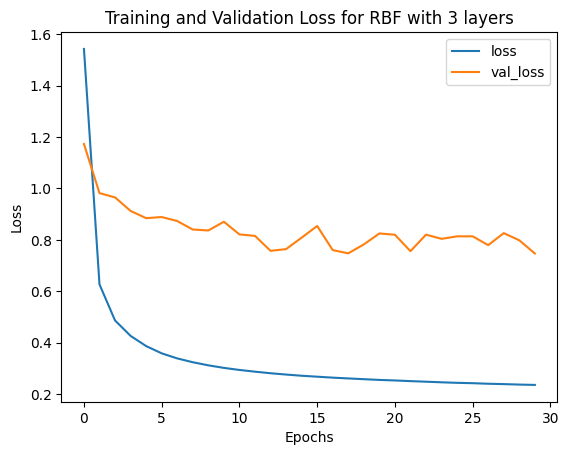

In [ ]:
hist = history_RBF3.history
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label='val_loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for RBF with 3 layers')
plt.legend()

# Show plot
plt.show()

In [ ]:
# if model:
#   del model
from tensorflow.keras import models

# Define the first RBF layer
rbfLayer1 = RBFLayer(40,
                    initializer=kmeans_initializer.InitCentersKMeans(X_tr),
                    betas=0.25,
                    input_shape=([18]))

# Create a Keras functional model with the first RBF layer as input
model_input = layers.Input(shape=(18,))
x = rbfLayer1(model_input)
model1 = models.Model(inputs=model_input, outputs=x)

# Extract the output of the first RBF layer as the new dataset for the second layer
X_rbfLayer1_output = model1.predict(X_tr)

# Define the second RBF layer with the new dataset
rbfLayer2 = RBFLayer(40,  # Adjust the number of hidden units as needed
                    initializer=kmeans_initializer.InitCentersKMeans(X_rbfLayer1_output),
                    betas=0.25)

# Build the model with two RBF layers
model = keras.models.Sequential()
model.add(rbfLayer1)
model.add(rbfLayer2)
model.add(layers.Dense(1))  # Output layer

model.compile(loss='mae', optimizer=RMSprop())
time1 = time.time()
# Train the model
history_RBF2 = model.fit(X_tr, y_tr,
                    epochs=30,
                    batch_size=1024,
                    validation_data=(X_Val, y_Val))

time2 = time.time()
span_RBF2 = time2 - time1

36841/36841 [==============================] - 41s 1ms/step
Epoch 1/30
1152/1152 [==============================] - 4s 3ms/step - loss: 1.9176 - val_loss: 1.3863
Epoch 2/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.9500 - val_loss: 1.1774
Epoch 3/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.7947 - val_loss: 1.1119
Epoch 4/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.7140 - val_loss: 1.1445
Epoch 5/30
1152/1152 [==============================] - 4s 3ms/step - loss: 0.6576 - val_loss: 1.0292
Epoch 6/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.6145 - val_loss: 0.9931
Epoch 7/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.5814 - val_loss: 0.9785
Epoch 8/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.5569 - val_loss: 0.9632
Epoch 9/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.5378 - val_loss: 0.9492
Epoch 10/30
1152/1152 

In [ ]:
y_pred_RBF2 = model.predict(X_Test,
                           batch_size = 2048)
print(f'{span_RBF2} sec')
r2_score(y_Test, y_pred_RBF2)

90/90 [==============================] - 0s 1ms/step
104.59955954551697 sec


0.855359045101034

In [ ]:
mse_RBF2 = mean_squared_error(y_Test, y_pred_RBF2)

In [ ]:
mae_RBF2 = mean_absolute_error(y_Test, y_pred_RBF2)

In [ ]:
mse_RBF2, mae_RBF2

NameError: name 'mae_RBF2' is not defined

In [ ]:
span_RBF2

104.59955954551697

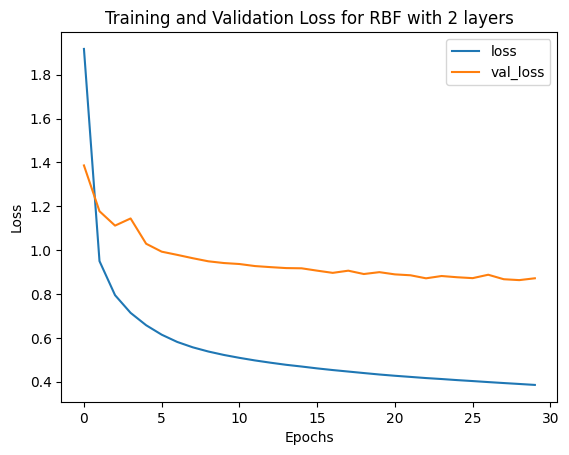

In [ ]:
hist = history_RBF2.history
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label='val_loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for RBF with 2 layers')
plt.legend()

# Show plot
plt.show()

In [ ]:
# if model:
#   del model

# kfold = KFold(n_splits = 1)
# histories_RBF1 = []
rbfLayer = RBFLayer(40,
                      initializer= kmeans_initializer.InitCentersKMeans(X_tr),
                      betas = 0.25,
                      input_shape = ([18]))

ins_model = keras.models.Sequential()
ins_model.add(rbfLayer)
ins_model.add(layers.Dense(1))
ins_model.compile(loss = 'mae',
                    optimizer = RMSprop())

time1 = time.time()
history_RBF1 = ins_model.fit(X_tr, y_tr,
                          epochs = 30,
                          batch_size = 1024,
                          validation_data = (X_Val, y_Val)
                          )

time2 = time.time()
span_RBF1 = time2 - time1
# histories.append(history)

Epoch 1/30
1152/1152 [==============================] - 4s 3ms/step - loss: 2.5339 - val_loss: 1.7399
Epoch 2/30
1152/1152 [==============================] - 3s 3ms/step - loss: 1.4212 - val_loss: 1.6488
Epoch 3/30
1152/1152 [==============================] - 3s 3ms/step - loss: 1.2879 - val_loss: 1.5493
Epoch 4/30
1152/1152 [==============================] - 3s 3ms/step - loss: 1.1844 - val_loss: 1.4815
Epoch 5/30
1152/1152 [==============================] - 3s 3ms/step - loss: 1.0993 - val_loss: 1.3976
Epoch 6/30
1152/1152 [==============================] - 3s 2ms/step - loss: 1.0139 - val_loss: 1.3367
Epoch 7/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.9483 - val_loss: 1.3566
Epoch 8/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.8920 - val_loss: 1.2582
Epoch 9/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.8412 - val_loss: 1.2306
Epoch 10/30
1152/1152 [==============================] - 3s 3ms/step - loss: 0.799

In [ ]:
y_pred_RBF1 = ins_model.predict(X_Test,
                           batch_size = 2048)
print(f'{span_RBF1} sec')
r2_score(y_Test, y_pred_RBF1)

90/90 [==============================] - 0s 1ms/step
90.32287073135376 sec


0.825064153305436

In [ ]:
mse_RBF1 = mean_squared_error(y_Test, y_pred_RBF1)

In [ ]:
mae_RBF1 = mean_absolute_error(y_Test, y_pred_RBF1)

In [ ]:
mse_RBF1, mae_RBF1

NameError: name 'mae_RBF1' is not defined

In [ ]:
span_RBF1

90.32287073135376

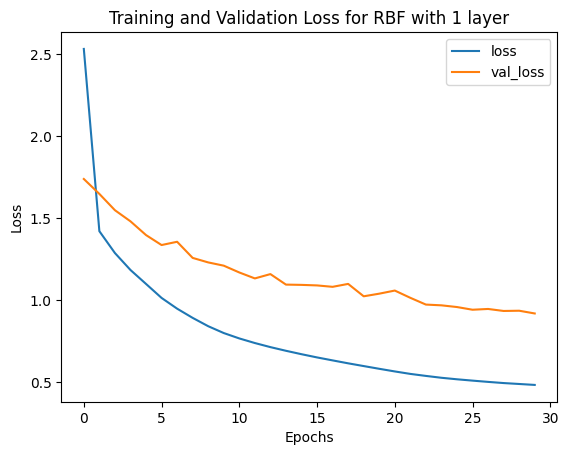

In [ ]:
hist = history_RBF1.history
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label='val_loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for RBF with 1 layer')
plt.legend()

# Show plot
plt.show()

In [ ]:
from sklearn.neural_network import MLPRegressor

Iteration 1, loss = 0.41388743
Epoch 1/50 - Training Loss: 0.1376 - Validation Loss: 0.7886
Iteration 2, loss = 0.02030505
Epoch 2/50 - Training Loss: 0.1264 - Validation Loss: 0.7744
Iteration 3, loss = 0.01889544
Epoch 3/50 - Training Loss: 0.1228 - Validation Loss: 0.7811
Iteration 4, loss = 0.01813227
Epoch 4/50 - Training Loss: 0.1202 - Validation Loss: 0.7872
Iteration 5, loss = 0.01754775
Epoch 5/50 - Training Loss: 0.1178 - Validation Loss: 0.8013
Iteration 6, loss = 0.01702788
Epoch 6/50 - Training Loss: 0.1171 - Validation Loss: 0.8144
Iteration 7, loss = 0.01648785
Epoch 7/50 - Training Loss: 0.1143 - Validation Loss: 0.8277
Iteration 8, loss = 0.01598323
Epoch 8/50 - Training Loss: 0.1114 - Validation Loss: 0.8426
Iteration 9, loss = 0.01548079
Epoch 9/50 - Training Loss: 0.1083 - Validation Loss: 0.8616
Iteration 10, loss = 0.01503073
Epoch 10/50 - Training Loss: 0.1065 - Validation Loss: 0.8803
Iteration 11, loss = 0.01461289
Epoch 11/50 - Training Loss: 0.1045 - Validati

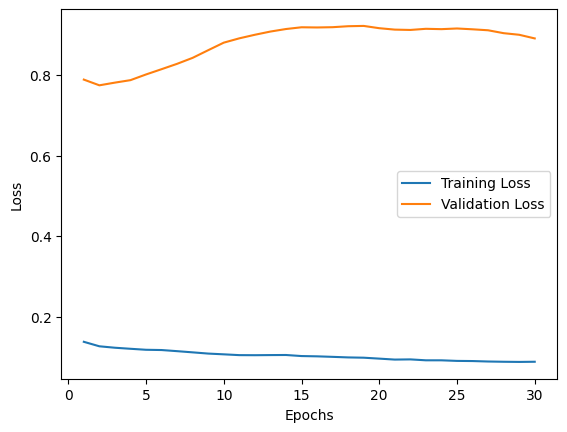

In [ ]:
import time
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np


mlp_model3 = MLPRegressor(hidden_layer_sizes=(40,40,40), learning_rate = 'adaptive', verbose = True, max_iter=10, random_state=42)

# Lists to store training and validation losses for each epoch
train_losses = []
val_losses = []
time_mlp_start = time.time()
for epoch in range(30):
    # Training on the training set
    mlp_model3.partial_fit(X_tr, y_tr)

    # Predict on the training set and calculate loss
    y_train_pred = mlp_model3.predict(X_tr)
    train_loss = mean_absolute_error(y_tr, y_train_pred)
    train_losses.append(train_loss)

    # Predict on the validation set and calculate loss
    y_val_pred = mlp_model3.predict(X_Val)
    val_loss = mean_absolute_error(y_Val, y_val_pred)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{50} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')
time_mlp_end = time.time()
time_length_MLP3 = time_mlp_end - time_mlp_start
# Plot or analyze the training and validation losses over epochs if needed
# For example, if using matplotlib:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
mlp_model3.score(X_Test, y_Test)

0.8504154875087522

In [ ]:
y_pred_MLP3 = mlp_model3.predict(X_Test)
r2_score(y_Test, y_pred_MLP3)

0.8504154875087522

In [ ]:
time_length_MLP3

759.8784403800964

In [ ]:
mse_MLP3 = mean_squared_error(y_Test, y_pred_MLP3)

In [ ]:
mae_MLP3 = mean_absolute_error(y_Test, y_pred_MLP3)

In [ ]:
mse_MLP3, mae_MLP3

(1.5721507392850143, 0.8981967432061231)

Iteration 1, loss = 0.68829089
Epoch 1/30 - Training Loss: 0.1444 - Validation Loss: 0.8077
Iteration 2, loss = 0.02049907
Epoch 2/30 - Training Loss: 0.1294 - Validation Loss: 0.8018
Iteration 3, loss = 0.01887773
Epoch 3/30 - Training Loss: 0.1257 - Validation Loss: 0.8087
Iteration 4, loss = 0.01806120
Epoch 4/30 - Training Loss: 0.1209 - Validation Loss: 0.8175
Iteration 5, loss = 0.01747896
Epoch 5/30 - Training Loss: 0.1169 - Validation Loss: 0.8207
Iteration 6, loss = 0.01696438
Epoch 6/30 - Training Loss: 0.1149 - Validation Loss: 0.8204
Iteration 7, loss = 0.01647674
Epoch 7/30 - Training Loss: 0.1144 - Validation Loss: 0.8239
Iteration 8, loss = 0.01601271
Epoch 8/30 - Training Loss: 0.1138 - Validation Loss: 0.8288
Iteration 9, loss = 0.01555319
Epoch 9/30 - Training Loss: 0.1125 - Validation Loss: 0.8360
Iteration 10, loss = 0.01515217
Epoch 10/30 - Training Loss: 0.1115 - Validation Loss: 0.8411
Iteration 11, loss = 0.01478506
Epoch 11/30 - Training Loss: 0.1095 - Validati

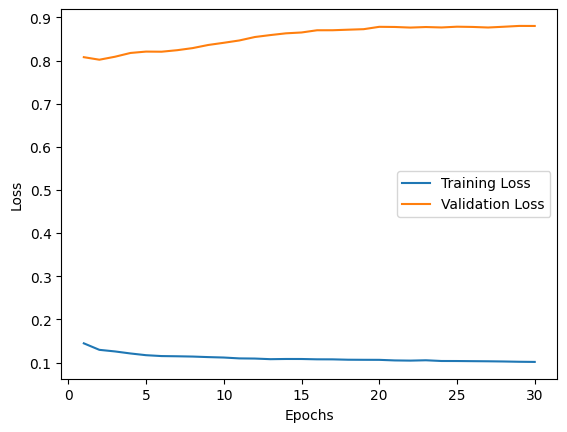

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Assuming X_train, y_train, X_val, y_val are your training and validation sets

mlp_model2 = MLPRegressor(hidden_layer_sizes=(40,40), learning_rate = 'adaptive', verbose = True, max_iter=10, random_state=42)

# Lists to store training and validation losses for each epoch
train_losses = []
val_losses = []
time_mlp_start = time.time()
for epoch in range(30):  # adjust the number of epochs as needed
    # Train on the training set
    mlp_model2.partial_fit(X_tr, y_tr)

    # Predict on the training set and calculate loss
    y_train_pred = mlp_model2.predict(X_tr)
    train_loss = mean_absolute_error(y_tr, y_train_pred)
    train_losses.append(train_loss)

    # Predict on the validation set and calculate loss
    y_val_pred = mlp_model2.predict(X_Val)
    val_loss = mean_absolute_error(y_Val, y_val_pred)
    val_losses.append(val_loss)

    # Print or log the training and validation losses for each epoch
    print(f'Epoch {epoch + 1}/{30} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')
time_mlp_end = time.time()
time_length_MLP2 = time_mlp_end - time_mlp_start
# Plot or analyze the training and validation losses over epochs if needed
# For example, if using matplotlib:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
mlp_model2.score(X_Test, y_Test)

0.8520244134619284

In [ ]:
y_pred_MLP2 = mlp_model2.predict(X_Test)

In [ ]:
time_length_MLP2

443.6926565170288

In [ ]:
mse_MLP2 = mean_squared_error(y_Test, y_pred_MLP2)

In [ ]:
mae_MLP2 = mean_absolute_error(y_Test, y_pred_MLP2)

In [ ]:
mse_MLP2, mae_MLP2

(1.5552407391478764, 0.8847139569684533)

Iteration 1, loss = 1.57577273
Epoch 1/30 - Training Loss: 0.1711 - Validation Loss: 0.8663
Iteration 2, loss = 0.02623296
Epoch 2/30 - Training Loss: 0.1386 - Validation Loss: 0.8328
Iteration 3, loss = 0.02173478
Epoch 3/30 - Training Loss: 0.1301 - Validation Loss: 0.8305
Iteration 4, loss = 0.02060741
Epoch 4/30 - Training Loss: 0.1274 - Validation Loss: 0.8262
Iteration 5, loss = 0.02008486
Epoch 5/30 - Training Loss: 0.1261 - Validation Loss: 0.8254
Iteration 6, loss = 0.01977228
Epoch 6/30 - Training Loss: 0.1251 - Validation Loss: 0.8240
Iteration 7, loss = 0.01953364
Epoch 7/30 - Training Loss: 0.1241 - Validation Loss: 0.8240
Iteration 8, loss = 0.01931874
Epoch 8/30 - Training Loss: 0.1227 - Validation Loss: 0.8244
Iteration 9, loss = 0.01916422
Epoch 9/30 - Training Loss: 0.1221 - Validation Loss: 0.8257
Iteration 10, loss = 0.01905286
Epoch 10/30 - Training Loss: 0.1215 - Validation Loss: 0.8290
Iteration 11, loss = 0.01896017
Epoch 11/30 - Training Loss: 0.1210 - Validati

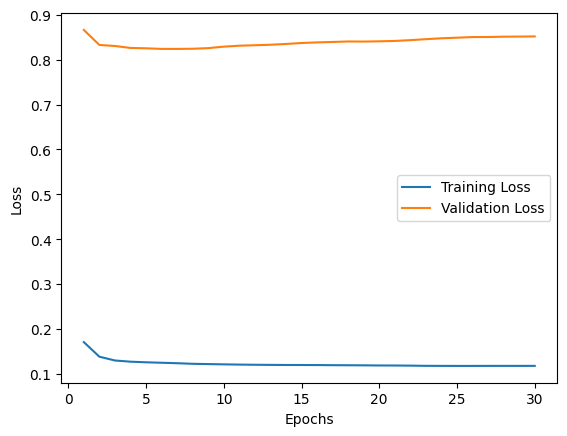

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Assuming X_train, y_train, X_val, y_val are your training and validation sets

mlp_model1 = MLPRegressor(hidden_layer_sizes=(40), learning_rate = 'adaptive', verbose = True, max_iter=10, random_state=42)

# Lists to store training and validation losses for each epoch
train_losses = []
val_losses = []
time_mlp_start = time.time()
for epoch in range(30):  # adjust the number of epochs as needed
    # Train on the training set
    mlp_model1.partial_fit(X_tr, y_tr)

    # Predict on the training set and calculate loss
    y_train_pred = mlp_model1.predict(X_tr)
    train_loss = mean_absolute_error(y_tr, y_train_pred)
    train_losses.append(train_loss)

    # Predict on the validation set and calculate loss
    y_val_pred = mlp_model1.predict(X_Val)
    val_loss = mean_absolute_error(y_Val, y_val_pred)
    val_losses.append(val_loss)

    # Print or log the training and validation losses for each epoch
    print(f'Epoch {epoch + 1}/{30} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')
time_mlp_end = time.time()
time_length_MLP1 = time_mlp_end - time_mlp_start
# Plot or analyze the training and validation losses over epochs if needed
# For example, if using matplotlib:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
mlp_model1.score(X_Test, y_Test)

0.8597870227528338

In [ ]:
y_pred_MLP1 = mlp_model1.predict(X_Test)

In [ ]:
time_length_MLP1

105.51675176620483

In [ ]:
mse_MLP1 = mean_squared_error(y_Test, y_pred_MLP1)

In [ ]:
mae_MLP1 = mean_absolute_error(y_Test, y_pred_MLP1)

In [ ]:
mse_MLP1, mae_MLP1

(1.4736548066724682, 0.8555258932082633)